<a href="https://colab.research.google.com/github/rhiats/Sepsis_Stratification/blob/main/Identification_of_Sepsis_Patients_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Identification of Sepsis Patients and Exploratory Data Analysis**

Person diagnosed with Sepsis using ICD Code.

Admissions- breakdown of insurance type

Admissions - gender

Prescriptions - Top 5 drugs

Prescriptions - Distribution number of drugs per patient

References:

https://physionet.org/content/mimic3-carevue/1.4/

https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

https://catalyst.nejm.org/doi/pdf/10.1056/CAT.22.0084

https://dl.acm.org/doi/pdf/10.1145/3014812.3014874

https://link.springer.com/article/10.1007/s11606-018-4760-8

https://www.nature.com/articles/s41467-023-37653-z

https://www.nature.com/articles/s41598-022-05088-z

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df_admissions=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/ADMISSIONS.csv.gz', compression='gzip')
df_patients=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/PATIENTS.csv.gz', compression='gzip')
df_presciptions=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/PRESCRIPTIONS.csv.gz', compression='gzip')
df_mb=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/MICROBIOLOGYEVENTS.csv.gz', compression='gzip')
df_events=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/LABEVENTS.csv.gz', compression='gzip')
df_services=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/SERVICES.csv.gz', compression='gzip')
df_icd_diag=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/DIAGNOSES_ICD.csv.gz', compression='gzip')
chart_events_chunk=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/CHARTEVENTS.csv.gz', compression='gzip', usecols=['subject_id','charttime','value','valueuom'], na_filter=False, chunksize=10000)

<ipython-input-3-3b49b68e548a>:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_presciptions=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/PRESCRIPTIONS.csv.gz', compression='gzip')


**24 Hour Reference Table**

In [ ]:
df_admissions['admittime'] = pd.to_datetime(df_admissions['admittime'], infer_datetime_format=True)
df_admissions['admittime_24']= df_admissions['admittime'] + pd.Timedelta(hours=24)
df_time_range=df_admissions[['subject_id','admittime','admittime_24']]
df_time_range.drop_duplicates(inplace=True)
df_time_range.to_pickle("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/df_time_range.pkl")

<ipython-input-4-86483a13871f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_range.drop_duplicates(inplace=True)


**Identify Sepsis Patients**

In [ ]:
def preprocess_str(x):
  """
    Find patients diagnosed with Sepsis using ICD9 codes.
    @p: pandas series 'diagnosis'
    @r: dataframe with Sepsis patients
  """
  x=str(x)
  x=x.lower()
  return x

In [ ]:
df_icd_diag['icd_lower']=df_icd_diag['icd9_code'].apply(preprocess_str)
df_severe_sep=df_icd_diag[df_icd_diag['icd_lower'].str.contains(pat = '99592')]
num_patients_sev_sep=df_severe_sep['subject_id'].nunique()
'There are {} patients in the ICU diagnosed with Severe Sepsis.'.format(num_patients_sev_sep)

'There are 1194 patients in the ICU diagnosed with Severe Sepsis.'

In [ ]:
df_sep_shock=df_icd_diag[df_icd_diag['icd_lower'].str.contains(pat = '78552')]
num_patients_sep_shock=df_sep_shock['subject_id'].nunique()
'There are {} patients in the ICU diagnosed with Septic Shock.'.format(num_patients_sep_shock)

'There are 763 patients in the ICU diagnosed with Septic Shock.'

In [ ]:
df_sep=pd.concat([df_severe_sep, df_sep_shock], ignore_index=True)

In [ ]:
sub_id_sep=list(set(df_sep['subject_id'].to_list()))
'There are {} patients in the ICU diagnosed with Sepsis.'.format(len(sub_id_sep))

'There are 1322 patients in the ICU diagnosed with Sepsis.'

**Heart Rate (BPM) Dataset**

In [ ]:
bpm_df_lst=[chunk[(chunk['valueuom']=='bpm') | (chunk['valueuom']=='BPM')] for chunk in chart_events_chunk]
for i in range(len(bpm_df_lst)-1, 0, -1):
    if bpm_df_lst[i].empty:
        del bpm_df_lst[i]
bpm_df=pd.concat(bpm_df_lst)
bpm_df['charttime'] = pd.to_datetime(bpm_df['charttime'], infer_datetime_format=True)
bpm_df=pd.merge(df_time_range,bpm_df, how='inner', on = 'subject_id')
bpm_df.head()

,subject_id,admittime,admittime_24,charttime,value,valueuom
0,2,2138-07-17 19:04:00,2138-07-18 19:04:00,2138-07-17 20:20:00,148,bpm
1,2,2138-07-17 19:04:00,2138-07-18 19:04:00,2138-07-17 20:30:00,131,bpm
2,2,2138-07-17 19:04:00,2138-07-18 19:04:00,2138-07-17 21:00:00,144,bpm
3,2,2138-07-17 19:04:00,2138-07-18 19:04:00,2138-07-17 22:00:00,140,bpm
4,3,2101-10-20 19:08:00,2101-10-21 19:08:00,2101-10-20 18:45:00,95,BPM


In [ ]:
bpm_df24=bpm_df.loc[(bpm_df['charttime']>=bpm_df['admittime'])&(bpm_df['charttime']<=bpm_df['admittime_24'])]
bpm_df24.to_pickle("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/bpm_df24.pkl")

**Breath per Minute**

In [ ]:
chart_events_chunk=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/CHARTEVENTS.csv.gz', compression='gzip', usecols=['subject_id','charttime','value','valueuom'], na_filter=False, chunksize=10000)
breath_df_lst=[chunk[chunk['valueuom']=='Breath'] for chunk in chart_events_chunk]
for i in range(len(breath_df_lst)-1, 0, -1):
    if breath_df_lst[i].empty:
        del breath_df_lst[i]
breath_df=pd.concat(breath_df_lst)
breath_df['charttime'] = pd.to_datetime(breath_df['charttime'], infer_datetime_format=True)
breath_df=pd.merge(df_time_range,breath_df, how='inner', on = 'subject_id')
breath_df24=breath_df.loc[(breath_df['charttime']>=breath_df['admittime'])&(breath_df['charttime']<=breath_df['admittime_24'])]
breath_df24.head()
breath_df24.to_pickle("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/breath_df24.pkl")

**Blood Pressure**

In [ ]:
chart_events_chunk=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/CHARTEVENTS.csv.gz', compression='gzip', usecols=['subject_id','charttime','value','valueuom'], na_filter=False, chunksize=10000)
bp_df_lst=[chunk[chunk['valueuom']=='mmHg'] for chunk in chart_events_chunk]
for i in range(len(bp_df_lst)-1, 0, -1):
    if bp_df_lst[i].empty:
        del bp_df_lst[i]
bp_df=pd.concat(bp_df_lst)
bp_df['charttime'] = pd.to_datetime(bp_df['charttime'], infer_datetime_format=True)
bp_df=pd.merge(df_time_range,bp_df, how='inner', on = 'subject_id')
bp_df24=bp_df.loc[(bp_df['charttime']>=bp_df['admittime'])&(bp_df['charttime']<=bp_df['admittime_24'])]
bp_df24.head()
bp_df24.to_pickle("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/bp_df24.pkl")

**Chart Events Sepsis Patients**

In [ ]:
chart_events_chunk=pd.read_csv('/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/mimic-iii-clinical-database-carevue-subset-1.4/CHARTEVENTS.csv.gz', compression='gzip', usecols=['subject_id','charttime','value','valueuom','itemid'], na_filter=False, chunksize=10000)
sepsis_chart_events_df_lst=[chunk[chunk['subject_id'].isin(sub_id_sep)] for chunk in chart_events_chunk]
for i in range(len(sepsis_chart_events_df_lst)-1, 0, -1):
    if sepsis_chart_events_df_lst[i].empty:
        del sepsis_chart_events_df_lst[i]
sepsis_chart_events_df=pd.concat(sepsis_chart_events_df_lst)
sepsis_chart_events_df.head()
sepsis_chart_events_df.to_pickle("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/sepsis_chart_events_df.pkl")

**Number of Records in the Admissions Dataframe**

In [ ]:
'There are {} records in the admissions dataset'.format(df_admissions.shape[0])

'There are 26836 records in the admissions dataset'

**Number of Nans in the Admissions Dataset**

In [ ]:
'{} patient is missing a diagnosis'.format(df_admissions['diagnosis'].isna().sum())

'1 patient is missing a diagnosis'

In [ ]:
df_admissions.isna().sum()

**Distribution of Patients Gender**

  gender  subject_id
0      F         576
1      M         746


<ipython-input-24-25958caabdd6>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fem_mal_df, x='Gender', y="Count", palette="deep")


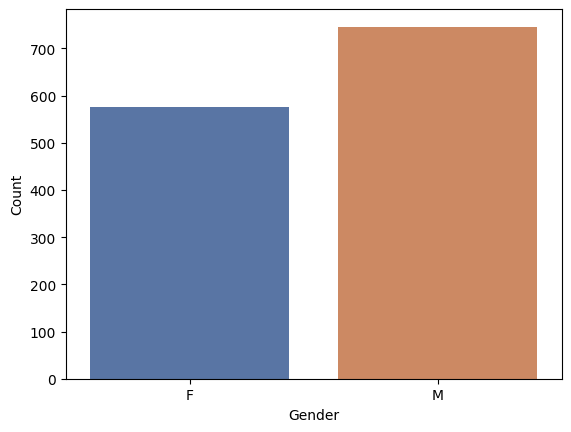

In [ ]:
df_gender=df_patients[df_patients['subject_id'].isin(sub_id_sep)][['subject_id','gender']]
df_gender.to_pickle("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/df_gender_sepsis.pkl")

fem_mal_df=df_gender.groupby(['gender']).count().reset_index()

print(fem_mal_df)

fem_mal_df.rename(columns={"subject_id": "Count","gender": "Gender"}, inplace=True)

sns.barplot(data=fem_mal_df, x='Gender', y="Count", palette="deep")

plt.savefig("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/gender.png")

**Distribution of Ethnicity within the ICU**

                                     Ethicity  Count
16                                      WHITE   1530
6                      BLACK/AFRICAN AMERICAN    225
15                      UNKNOWN/NOT SPECIFIED    151
1                                       ASIAN     44
12                                      OTHER     40
8                          HISPANIC OR LATINO     37
13                 PATIENT DECLINED TO ANSWER     15
14                           UNABLE TO OBTAIN     11
4                             ASIAN - CHINESE      6
0               AMERICAN INDIAN/ALASKA NATIVE      3
9              HISPANIC/LATINO - PUERTO RICAN      3
10                       MULTI RACE ETHNICITY      2
5                          ASIAN - VIETNAMESE      2
2                        ASIAN - ASIAN INDIAN      2
17                          WHITE - BRAZILIAN      2
11  NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER      1
7                          BLACK/CAPE VERDEAN      1
3                           ASIAN - CAMBODIAN 

<ipython-input-25-72296ca14bb3>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ethnicity_dist, x='Ethicity', y="Count", palette="deep")


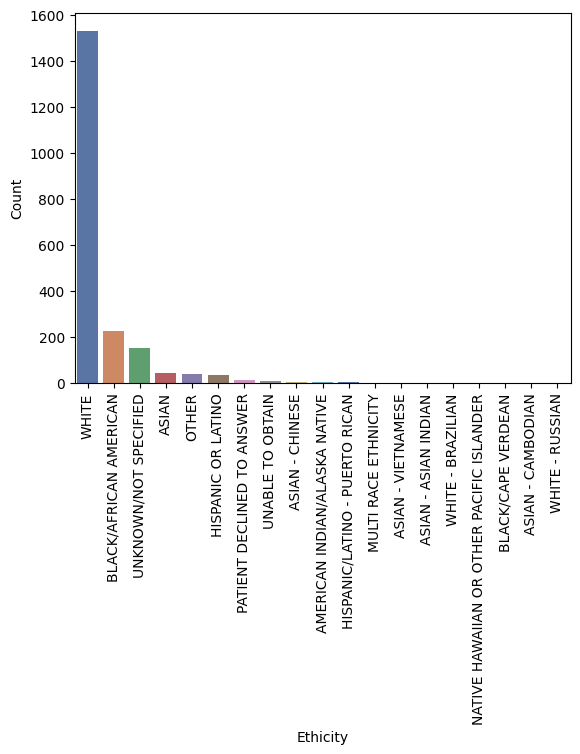

In [ ]:
df_ethnicity=df_admissions[df_admissions['subject_id'].isin(sub_id_sep)][['subject_id','ethnicity']]
df_ethnicity.to_pickle("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/df_ethnicity_sepsis.pkl")

df_ethnicity_dist=df_ethnicity.groupby(['ethnicity']).count().reset_index()

df_ethnicity_dist.rename(columns={"subject_id": "Count","ethnicity": "Ethicity"}, inplace=True)

df_ethnicity_dist.sort_values(by='Count', ascending=False, inplace=True)

print(df_ethnicity_dist)

sns.barplot(data=df_ethnicity_dist, x='Ethicity', y="Count", palette="deep")

plt.xticks(rotation = 90)

plt.savefig("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/ethnicity.png")

**Distribution of Insurance Types for Sepsis Patients**

    insurance  subject_id
0  Government          30
1    Medicaid          98
2    Medicare         876
3     Private         341
4    Self Pay          15


<ipython-input-26-bc366ab18494>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=insur_df_cnt, x='Insurance', y="Count", palette="deep")


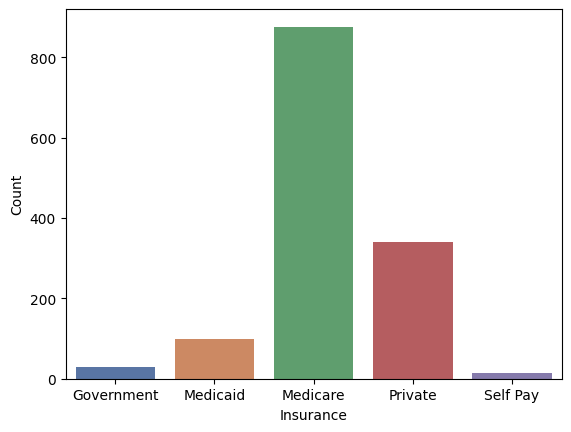

In [ ]:
df_insur_sepsis=df_admissions[df_admissions['subject_id'].isin(sub_id_sep)][['subject_id','insurance']]

df_insur_sepsis.drop_duplicates(subset=['subject_id','insurance'],inplace=True)

df_insur_sepsis.to_pickle("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/df_insur_sepsis.pkl")

insur_df_cnt=df_insur_sepsis.groupby(['insurance']).nunique().reset_index()

print(insur_df_cnt)

insur_df_cnt.rename(columns={"subject_id": "Count","insurance": "Insurance"}, inplace=True)

sns.barplot(data=insur_df_cnt, x='Insurance', y="Count", palette="deep")

plt.savefig("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/insurance.png")

**Top 3 Drugs used by Sepsis Patients in the ICU**

                      Drug  Count
923                     NS   1301
370                    D5W   1291
695   Iso-Osmotic Dextrose   1234
1113    Potassium Chloride   1162
679                Insulin   1087


<ipython-input-27-f275aec0109e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_5_drugs, x='Drug', y="Count", palette="deep")


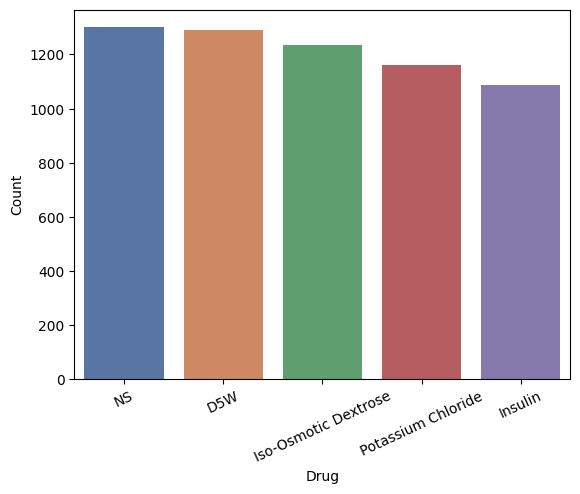

In [ ]:
df_drug_sep=df_presciptions[df_presciptions['subject_id'].isin(sub_id_sep)][['subject_id','drug']]
df_drug_sep.to_pickle("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/df_drug_sepsis.pkl")

df_drug=df_drug_sep.groupby(['drug']).nunique().reset_index()
df_drug.rename(columns={"subject_id": "Count","drug": "Drug"}, inplace=True)
df_top_5_drugs=df_drug.nlargest(5, 'Count')
print(df_top_5_drugs)
sns.barplot(data=df_top_5_drugs, x='Drug', y="Count", palette="deep")
plt.xticks(rotation = 25)

plt.savefig("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/top5Drugs.png")

**Distribution of Medications per Person**

     subject_id  Number of Medications
589       12613                    175
374        7985                    165
726       15952                    163
167        3683                    162
486       10434                    162
subject_id               14260.0
Number of Medications       54.0
dtype: float64


<ipython-input-28-4a29c6f7a385>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_drug_per_patient, x="Number of Medications",palette="Deep")


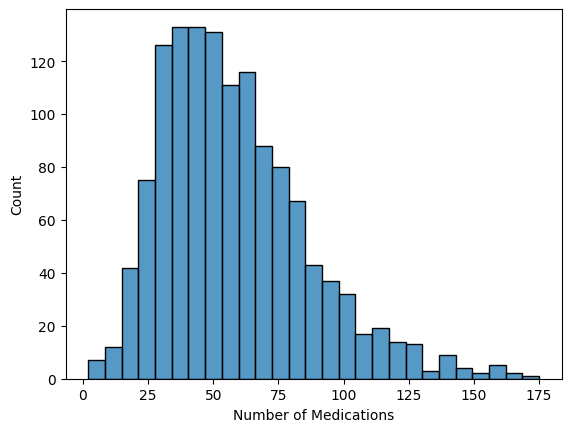

In [ ]:
df_drug_per_patient=df_drug_sep.groupby(['subject_id']).nunique().reset_index()
df_drug_per_patient.rename(columns={"drug": "Number of Medications"}, inplace=True)

df_drug_per_patient.to_pickle("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/df_drug_per_patient_sepsis.pkl")

print(df_drug_per_patient.nlargest(5, 'Number of Medications'))

print(df_drug_per_patient.median())
sns.histplot(data=df_drug_per_patient, x="Number of Medications",palette="Deep")

plt.savefig("/content/drive/MyDrive/assignments/Spring24/MLHealth/Final Project/Output/drugs_per_patient.png")